100%|██████████| 3973/3973 [00:09<00:00, 421.32it/s]
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 85s 657ms/step - accuracy: 0.1069 - loss: 3.6920 - val_accuracy: 0.6210 - val_loss: 1.5741 - learning_rate: 1.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 0.5457 - loss: 1.8146 - val_accuracy: 0.7566 - val_loss: 0.7509 - learning_rate: 1.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 0.6830 - loss: 1.0835 - val_accuracy: 0.7944 - val_loss: 0.6181 - learning_rate: 1.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 385ms/step - accuracy: 0.7536 - loss: 0.8360 - val_accuracy: 0.8042 - val_loss: 0.5818 - learning_rate: 1.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step - accuracy: 0.7922 - loss: 0.6847 - val_accuracy: 0.7944 - val_loss: 0.6058 - learning_rate: 1.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 387ms/step - accuracy: 0.8103 - loss: 0.6101 - val_accuracy: 0.8294 - val_loss: 0.5611 - learning_rate: 1.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 35s 392ms/step - acc

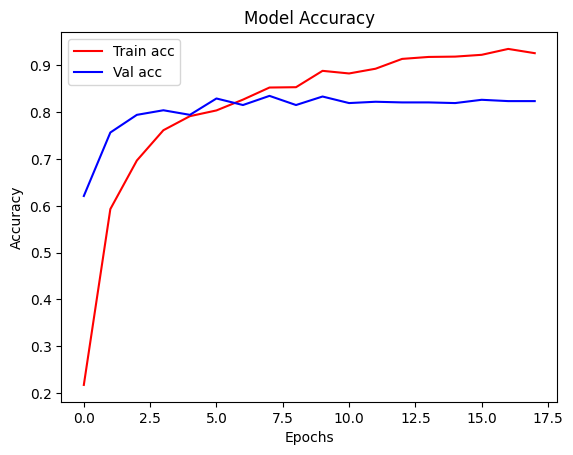

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ============================================================================
# 1. Daftar ras anjing yang digunakan sebagai label
# ============================================================================
# Ini adalah daftar 50 ras anjing yang akan diprediksi oleh model.
# Semua nama ras harus sesuai dengan nama ras yang ada di dataset.
CLASS_NAMES = [
    "labrador_retriever", "golden_retriever", "german_shepherd", "french_bulldog", "pug",
    "beagle", "siberian_husky", "pomeranian", "chihuahua", "yorkshire_terrier",
    "shih-tzu", "doberman", "boxer", "great_dane", "rottweiler",
    "border_collie", "basset", "maltese_dog", "irish_setter", "bernese_mountain_dog",
    "cocker_spaniel", "english_springer", "collie", "dachshund",
    "american_staffordshire_terrier", "staffordshire_bullterrier", "greyhound",
    "italian_greyhound", "miniature_schnauzer", "giant_schnauzer", "standard_schnauzer",
    "miniature_poodle", "standard_poodle", "toy_poodle", "dalmatian", "bluetick",
    "akita", "malamute", "samoyed", "keeshond", "whippet",
    "papillon", "pekinese", "pembroke", "norwegian_elkhound",
    "west_highland_white_terrier", "soft-coated_wheaten_terrier",
    "scottish_deerhound", "afghan_hound", "saluki"
]

# ============================================================================
# 2. Membaca file label dari dataset
# ============================================================================
# File labels.csv berisi ID gambar dan nama rasnya.
# Kita ambil hanya data yang rasnya termasuk dalam CLASS_NAMES.
labels_all = pd.read_csv("dog_data/labels.csv")
labels = labels_all[labels_all['breed'].isin(CLASS_NAMES)].reset_index(drop=True)

# ============================================================================
# 3. Mengonversi gambar menjadi array numerik
# ============================================================================
# X_data adalah tempat menyimpan gambar yang sudah diubah ukuran menjadi 224x224.
# preprocess_input digunakan untuk menyesuaikan gambar ke format MobileNetV2.
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')

# Mengubah nama ras menjadi format angka (one-hot encoding)
Y_data = label_binarize(labels['breed'], classes=CLASS_NAMES)

# Membaca gambar satu per satu dari folder dan memprosesnya
for i in tqdm(range(len(labels)), desc="Loading images"):
    img = image.load_img(f'dog_data/train/{labels["id"][i]}.jpg', target_size=(224, 224))
    img = image.img_to_array(img)  # ubah gambar ke array
    X_data[i] = preprocess_input(img)  # normalisasi agar cocok dengan MobileNetV2

# ============================================================================
# 4. Membagi dataset menjadi Train, Validation, dan Test
# ============================================================================
# Train: data yang digunakan untuk melatih model
# Validation: untuk mengecek apakah model overfitting
# Test: untuk evaluasi akhir
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# ============================================================================
# 5. Data Augmentation (menambah variasi gambar)
# ============================================================================
# Tujuannya agar model tidak "hapal gambar" dan lebih kuat saat melihat gambar baru.
datagen = ImageDataGenerator(
    rotation_range=20,        # memutar gambar hingga 20°
    width_shift_range=0.2,    # geser gambar ke kiri/kanan
    height_shift_range=0.2,   # geser gambar ke atas/bawah
    zoom_range=0.2,           # zoom in/out
    horizontal_flip=True,     # membalik gambar secara horizontal
    fill_mode='nearest'       # mengisi area kosong dengan warna sekitar
)
datagen.fit(X_train)

# ============================================================================
# 6. Menggunakan MobileNetV2 sebagai dasar model (Transfer Learning)
# ============================================================================
# MobileNetV2 sudah dilatih pada ImageNet, sehingga sangat baik mendeteksi pola dasar gambar.
# include_top=False berarti kita membuang layer klasifikasi bawaannya.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Kita kunci sebagian besar layer agar tidak ikut belajar lagi.
# Hanya 20 layer paling atas yang kita biarkan belajar ulang.
for layer in base_model.layers[:-20]:
    layer.trainable = False

# ============================================================================
# 7. Menambah layer baru untuk klasifikasi 50 ras
# ============================================================================
# GlobalAveragePooling2D → meratakan fitur menjadi satu dimensi
# Dropout → mencegah overfitting
# Dense → layer fully connected
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)  # layer belajar pola data
x = Dropout(0.2)(x)
preds = Dense(len(CLASS_NAMES), activation='softmax')(x)  # output probabilitas 50 kelas

# Membuat model lengkap
model = Model(inputs=base_model.input, outputs=preds)

# ============================================================================
# 8. Compile model
# ============================================================================
# optimizer Adam → stabil dan cocok untuk fine-tuning
# loss categorical_crossentropy → karena outputnya banyak kelas
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ============================================================================
# 9. Callback untuk membantu training tetap stabil
# ============================================================================
# EarlyStopping → berhenti jika model tidak membaik
# ReduceLROnPlateau → mengecilkan learning rate jika training lambat

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# ============================================================================
# 10. Training model
# ============================================================================
# Menggunakan datagen agar setiap epoch model melihat gambar yang sedikit berbeda.
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stop, reduce_lr]
)

# ============================================================================
# 11. Evaluasi model
# ============================================================================
# Test set digunakan untuk mengukur performa yang sebenarnya.
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# ============================================================================
# 12. Plot grafik akurasi
# ============================================================================
# Grafik ini menunjukkan perkembangan akurasi model selama training.
plt.plot(history.history['accuracy'], label='Train acc', color='r')
plt.plot(history.history['val_accuracy'], label='Val acc', color='b')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

# ============================================================================
# 13. Menyimpan model
# ============================================================================
# Model disimpan dalam format .h5 agar bisa digunakan kembali.
model.save("dog_breed_50.h5")